# Calculation of nonlocal corrections to transport coefficients

# Imports

In [1]:
from scipy import integrate
from scipy.linalg import solve_triangular, inv
from scipy.constants import pi as PI
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.colors as clr
plt.rc('font', family='serif')
plt.rc('text', usetex=False)

# Recursive Calculation

In [2]:
vlim=5.0
vnum=50
v=np.linspace(1e-10,vlim,num=vnum)
etatherm=np.logspace(-3,3,num=vnum)
chitherm=np.array([0., 0.1, 1, 5, 10, 100, 1000])

In [3]:
chi_mesh, eta_mesh, v_mesh = np.meshgrid(chitherm,etatherm,v, indexing="ij")
eta_curve=eta_mesh*v_mesh**4.0
chi_curve=chi_mesh*v_mesh**3.0

In [4]:
#m=1 case - calculate the g function matrix that provides the high mode corrections
#max l to start with
lmax = 20

In [5]:
def invert_mat_array(mat_arr):
    shape = mat_arr.shape[:-2]
    return np.array([[[inv(mat_arr[i,j,k]) for k in range(shape[2])] for j in range(shape[1])] for i in range(shape[0])])

In [6]:
def invert_mat_array2(mat_arr):
    shape = mat_arr.shape[:-2]
    return np.array([[inv(mat_arr[i,j])  for j in range(shape[1])] for i in range(shape[0])])

In [7]:
def calc_M(l, chi):
    ones = np.ones(chi.shape)
    val = l*(l+1)*0.5
    mat = val*np.identity(l+1)
    diag = np.tensordot(ones, mat, axes=0)
    submat = 0.5*np.eye(l+1, k=-1)
    subdiag = np.tensordot(chi, submat, axes=0)
    m = np.arange(0,l)
    supvals = -(l-m)*(l+m+1)
    supmat = np.diag(supvals, k=1)
    supdiag = np.tensordot(chi, supmat, axes=0)
    return diag + subdiag + supdiag

def calc_P(l, chi):
    ones = np.ones(chi.shape)
    m = np.arange(0,l+1)
    diag = (l+m+1)/(2*l+3)
    mat = np.diag(diag)
    return np.tensordot(ones, mat, axes=0)

def calc_N(l, chi):
    ones = np.ones(chi.shape)
    m = np.arange(0,l+1)
    diag = (l-m)/(2*l-1)
    mat = np.diag(diag)
    return np.tensordot(ones, mat, axes=0)

In [8]:
G1 = calc_M(1, chi_curve)

In [9]:
G = calc_M(lmax+1, chi_curve)
for l in tqdm(range(lmax,0,-1)):
    print(l)
    inv_G = invert_mat_array(G)
    M = calc_M(l, chi_curve)
    P = calc_P(l, chi_curve)
    N = calc_N(l+1, chi_curve)
    rhs = np.matmul(inv_G, N)[:,:,:,:l+1,:l+1]
    eta2 = np.tensordot(eta_curve**2, np.identity(l+1), axes=0)
    rhs = np.matmul(P, rhs)
    G = M + eta2*rhs

  0%|          | 0/20 [00:00<?, ?it/s]

20


  5%|▌         | 1/20 [00:02<00:39,  2.06s/it]

19


 10%|█         | 2/20 [00:04<00:36,  2.04s/it]

18


 15%|█▌        | 3/20 [00:05<00:32,  1.89s/it]

17


 20%|██        | 4/20 [00:07<00:29,  1.82s/it]

16


 25%|██▌       | 5/20 [00:08<00:25,  1.72s/it]

15


 30%|███       | 6/20 [00:09<00:21,  1.56s/it]

14


 35%|███▌      | 7/20 [00:10<00:17,  1.35s/it]

13


 40%|████      | 8/20 [00:11<00:13,  1.12s/it]

12


 45%|████▌     | 9/20 [00:11<00:10,  1.06it/s]

11


 50%|█████     | 10/20 [00:12<00:07,  1.26it/s]

10


 55%|█████▌    | 11/20 [00:12<00:06,  1.46it/s]

9


 60%|██████    | 12/20 [00:13<00:04,  1.65it/s]

8


 65%|██████▌   | 13/20 [00:13<00:03,  1.83it/s]

7


 70%|███████   | 14/20 [00:13<00:02,  2.02it/s]

6


 75%|███████▌  | 15/20 [00:14<00:02,  2.17it/s]

5


 80%|████████  | 16/20 [00:14<00:01,  2.30it/s]

4


 85%|████████▌ | 17/20 [00:15<00:01,  2.40it/s]

3


 90%|█████████ | 18/20 [00:15<00:00,  2.49it/s]

2


 95%|█████████▌| 19/20 [00:15<00:00,  2.59it/s]

1


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


In [10]:
Gcart = np.array([[G[:,:,:,0,0], 0.5*G[:,:,:,0,1], np.zeros(G[:,:,:,0,0].shape)],[G[:,:,:,1,0], G[:,:,:,1,1], np.zeros(G[:,:,:,0,0].shape)],[np.zeros(G[:,:,:,0,0].shape), np.zeros(G[:,:,:,0,0].shape), -0.5*G[:,:,:,1,1]]])
Gcart1 = np.array([[G1[:,:,:,0,0], 0.5*G1[:,:,:,0,1], np.zeros(G1[:,:,:,0,0].shape)],[G1[:,:,:,1,0], G1[:,:,:,1,1], np.zeros(G1[:,:,:,0,0].shape)],[np.zeros(G1[:,:,:,0,0].shape), np.zeros(G1[:,:,:,0,0].shape), -0.5*G1[:,:,:,1,1]]])

In [11]:
Gcart = np.transpose(Gcart, axes=[2,3,4,0,1])
Gcart1 = np.transpose(Gcart1, axes=[2,3,4,0,1])

In [12]:
zeros = np.zeros(eta_curve.shape)
K = np.array([[0.3333*eta_curve**2,zeros,zeros],[zeros,zeros,zeros],[zeros,zeros,zeros]]) 
K = np.transpose(K, axes=[2,3,4,0,1])

In [13]:
Gcart = Gcart + K
Gcart1 = Gcart1 + K

In [14]:
inv_Gcart = invert_mat_array(Gcart)
inv_Gcart1 = invert_mat_array(Gcart1)

# Integration

In [27]:
def integrator(powr, M):
    ones = np.ones((3,3))
    v_meshp = np.tensordot(v_mesh,ones, axes=0)
    maxwell=0.0635*np.exp(-0.5*v_meshp**2.0)
    integrand=M*maxwell*(v_meshp**powr)
    return integrate.simps(integrand, v ,axis=2)

In [28]:
mv7 = 4*PI*integrator(7, inv_Gcart)
mv9 = 4*PI*integrator(9, inv_Gcart)
mv11 = 4*PI*integrator(11, inv_Gcart)

mv7p = 4*PI*integrator(7, inv_Gcart1)
mv9p = 4*PI*integrator(9, inv_Gcart1)
mv11p = 4*PI*integrator(11, inv_Gcart1)


In [29]:
invmv7 = invert_mat_array2(mv7)
invmv7p = invert_mat_array2(mv7p)

In [30]:
rhs = np.matmul(mv9,np.matmul(invmv7, mv9))
kappa = (mv11 - rhs)/12

rhs = np.matmul(mv9p,np.matmul(invmv7p, mv9p))
kappa1 = (mv11p - rhs)/12

In [31]:
ident = np.identity(3)
rhs = 2.5*np.tensordot(np.ones(mv7.shape[:-2]), ident, axes=0)
beta = 0.5*np.matmul(invmv7, mv9) - rhs

In [32]:
alpha = 3*invmv7

(0.0, 5.0)

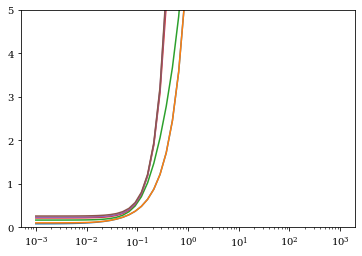

In [33]:
plt.semilogx(etatherm, alpha[0,:,0,0])
plt.semilogx(etatherm, alpha[1,:,0,0])
plt.semilogx(etatherm, alpha[2,:,0,0])
plt.semilogx(etatherm, alpha[3,:,0,0])
plt.semilogx(etatherm, alpha[4,:,0,0])
plt.semilogx(etatherm, alpha[5,:,0,0])
plt.ylim(0,5)

(-1.0, 5.0)

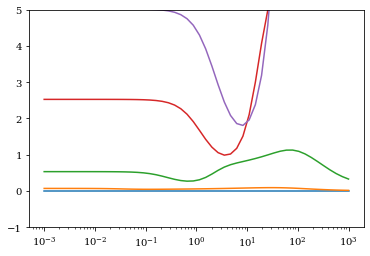

In [34]:
plt.semilogx(etatherm, alpha[0,:,1,0])
plt.semilogx(etatherm, alpha[1,:,1,0])
plt.semilogx(etatherm, alpha[2,:,1,0])
plt.semilogx(etatherm, alpha[3,:,1,0])
plt.semilogx(etatherm, alpha[4,:,1,0])
plt.semilogx(etatherm, alpha[5,:,1,0])
plt.ylim(-1,5)

(-2.5, 1.5)

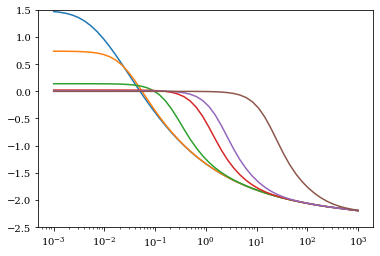

In [35]:
plt.semilogx(etatherm, beta[0,:,0,0])
plt.semilogx(etatherm, beta[1,:,0,0])
plt.semilogx(etatherm, beta[2,:,0,0])
plt.semilogx(etatherm, beta[3,:,0,0])
plt.semilogx(etatherm, beta[4,:,0,0])
plt.semilogx(etatherm, beta[5,:,0,0])
plt.ylim(-2.5,1.5)

(-0.5, 0.5)

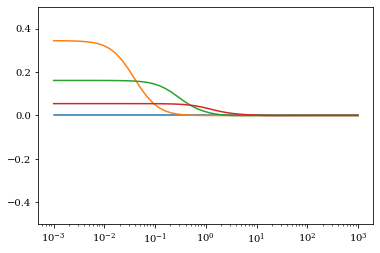

In [36]:
plt.semilogx(etatherm, -beta[0,:,1,0])
plt.semilogx(etatherm, -beta[1,:,1,0])
plt.semilogx(etatherm, -beta[2,:,1,0])
plt.semilogx(etatherm, -beta[3,:,1,0])
plt.ylim(-0.5,0.5)

(0.0, 14.0)

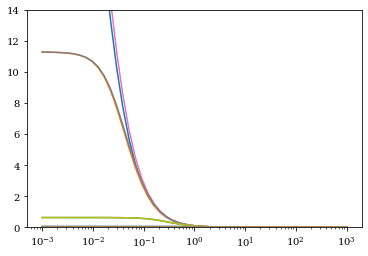

In [37]:
plt.semilogx(etatherm, kappa[0,:,0,0])
plt.semilogx(etatherm, kappa[1,:,0,0])
plt.semilogx(etatherm, kappa[2,:,0,0])
plt.semilogx(etatherm, kappa[3,:,0,0])
plt.semilogx(etatherm, kappa[4,:,0,0])
plt.semilogx(etatherm, kappa[5,:,0,0])
plt.semilogx(etatherm, kappa1[0,:,0,0])
plt.semilogx(etatherm, kappa1[1,:,0,0])
plt.semilogx(etatherm, kappa1[2,:,0,0])
plt.semilogx(etatherm, kappa1[3,:,0,0])
plt.semilogx(etatherm, kappa1[4,:,0,0])
plt.semilogx(etatherm, kappa1[5,:,0,0])
plt.ylim(0,14)

(0.0, 5.0)

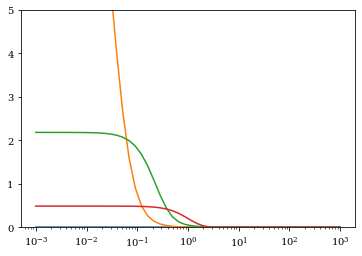

In [38]:
plt.semilogx(etatherm, -kappa[0,:,1,0])
plt.semilogx(etatherm, -kappa[1,:,1,0])
plt.semilogx(etatherm, -kappa[2,:,1,0])
plt.semilogx(etatherm, -kappa[3,:,1,0])
plt.ylim(0,5)

# Plotting